# Introduccion

En este trabajo práctico se aplicarán técnicas de Machine Learning no supervisado para analizar un conjunto de datos: (dataset) relacionado con teléfonos celulares. El objetivo de este estudio es descubrir patrones ocultos en los datos y agrupar los teléfonos en diferentes categorías basadas en sus características técnicas, sin necesidad de una variable objetivo predefinida.

El dataset, adjunto a este trabajo, contiene las siguientes columnas:
- phone_name (string) nombre del equipo
- brand: (string) marca del equipo
- os: (string) sistema operativo
- inches: (float) pulgadas de la pantalla
- resolution: (string) resolucion de la pantalla
- battery: (integer) potencia de la bateria
- battery_type: (string) tipo de bateria
- ra:m(GB): (integer) memoria ram
- announcement_date: (date) fecha de lanzamiento del equipo
- weigh:t(g): (integer) peso en gramos del equipo
- storag:e(GB): (integer) memoria de almacenamiento
- video_720p: (boolean)
- video_1080p: (boolean)
- video_4K: (boolean)
- video_8K: (boolean)
- video_30fps: (boolean)
- video_60fps: (boolean)
- video_120fps: (boolean)
- video_240fps: (boolean)
- video_480fps: (boolean)
- video_960fps: (boolean)
- price(USD): (integer) precio en dolares del equipo


Para el análisis, se utilizará el algoritmo como K-means, que permitirá identificar grupos o clusters de teléfonos con propiedades similares. Se contrastarán las posibles grupos con el metodo del codo y el coeficiente de Silhouette.

El proceso abarcará desde la exploración y preprocesamiento de los datos, hasta la aplicación del modelo de clustering y la interpretación de los resultados, con el fin de obtener una mejor comprensión de las características que determinan las similitudes entre los distintos dispositivos.

# Hipotesis

Existen distintos segmentos de dispositivos móviles que se agrupan de manera natural según sus características técnicas, como sistema operativo, tamaño de pantalla, resolución, batería, memoria RAM, entre otros, y estos segmentos pueden revelar preferencias o tendencias de consumo en el mercado de teléfonos móviles. 

El mercado de los teléfonos móviles es extremadamente diverso, con una amplia variedad de dispositivos que van desde los modelos más básicos hasta los más avanzados. Estos teléfonos varían en términos de especificaciones técnicas, como el sistema operativo, tamaño de pantalla, capacidad de la batería, cantidad de RAM y resolución de pantalla. Las decisiones de compra de los consumidores también dependen en gran medida de estos factores, junto con el precio. Sin embargo, no siempre es evidente cómo se agrupan estos dispositivos en el mercado ni cómo se relacionan sus características entre sí.

Creemos que, en función de las características técnicas de los dispositivos móviles, es posible identificar distintos grupos o "clusters" que representan segmentos de dispositivos similares. Estos grupos podrían reflejar diferentes nichos de mercado (como teléfonos económicos, teléfonos de gama alta, teléfonos orientados al gaming, etc.), y su análisis podría proporcionar información valiosa sobre las preferencias y prioridades de los usuarios en cuanto a las características que consideran más importantes.

 # Desarrollo 

In [2]:
#En primer lugar importo las librerias que voy a utilizar:

import numpy as np
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples

#Creo el dataframe 'elements' con el contenido del csv

elements = pd.read_csv('cleaned_all_phones.csv')
elements.head()

,phone_name,brand,os,inches,resolution,battery,battery_type,ram(GB),announcement_date,weight(g),...,video_1080p,video_4K,video_8K,video_30fps,video_60fps,video_120fps,video_240fps,video_480fps,video_960fps,price(USD)
0,Y6II Compact,Huawei,Android 5.1,5.0,720x1280,2200,Li-Po,2,2016-09-01,140.0,...,False,False,False,True,False,False,False,False,False,120.0
1,K20 plus,LG,Android 7.0,5.3,720x1280,2700,Li-Ion,2,2016-12-01,140.0,...,True,False,False,True,False,False,False,False,False,100.0
2,P8 Lite (2017),Huawei,Android 7.0,5.2,1080x1920,3000,Li-Ion,4,2017-01-01,147.0,...,True,False,False,True,False,False,False,False,False,420.0
3,Redmi Note 4,Xiaomi,Android 6.0,5.5,1080x1920,4100,Li-Po,4,2017-01-01,165.0,...,True,False,False,True,False,True,False,False,False,150.0
4,P10,Huawei,Android 7.0,5.1,1080x1920,3200,Li-Ion,4,2017-02-01,145.0,...,True,True,False,True,True,False,False,False,False,420.0


In [3]:
#Verifico la cantidad de nulos en mi dataframe
nulos = elements.isnull().sum()

print(nulos)

#En este caso, el dataset escogido no tiene valores en null

phone_name           0
brand                0
os                   0
inches               0
resolution           0
battery              0
battery_type         0
ram(GB)              0
announcement_date    0
weight(g)            0
storage(GB)          0
video_720p           0
video_1080p          0
video_4K             0
video_8K             0
video_30fps          0
video_60fps          0
video_120fps         0
video_240fps         0
video_480fps         0
video_960fps         0
price(USD)           0
dtype: int64


In [4]:
#En primer lugar transformo la columna de nombre del equipo en indice luego la dropeo

elements.index = elements['phone_name']
elements = elements.drop('phone_name', axis='columns')


#Procedo a combinar las columnas referidas "video_fps" para reducir la cantidad de columnas:
elements['video_fps'] = elements.apply(lambda row: 
                            30 if row['video_30fps'] else
                            60 if row['video_60fps'] else
                            120 if row['video_120fps'] else
                            240 if row['video_240fps'] else
                            480 if row['video_480fps'] else
                            960 if row['video_960fps'] else 0, axis=1)

#El mismo proceso para unificar las columnas referidas a la resolucion de video:

elements['video_resol'] = elements.apply(lambda row: 
                            720 if row['video_720p'] else
                            1080 if row['video_1080p'] else
                            3840 if row['video_4K'] else
                            7680 if row['video_8K'] else 0, axis=1)

# Se procede a eliminar las columnas combinadas.
elements = elements.drop(columns=['video_30fps','video_60fps','video_120fps','video_240fps','video_480fps','video_960fps','video_720p','video_1080p','video_4K','video_8K'])

In [5]:
#Depuracion de los datos:

#tomo lo que este a la izquierda de la 'x' para la resolucion de pantalla. Luego transoformo la columna a entero
elements['resolution'] = elements['resolution'].str.split('x').str[0]
elements['resolution'] = elements['resolution'].astype(int) 

#cambio el formato de la fecha por un entero presentando el año y elimino la columna original.
elements['fecha'] = elements['announcement_date'].str[:4].astype(int)

elements = elements.drop(columns=['announcement_date'])

label_encoder = LabelEncoder()

# Aplicar el LabelEncoder a la columna 'brand'
elements['brand'] = label_encoder.fit_transform(elements['brand'])

# Aplicar el LabelEncoder a la columna 'battery_type'
elements['battery_type'] = label_encoder.fit_transform(elements['battery_type'])


In [6]:

#Genero una función para extraer el número de versión del sistema operativo (columna os) 
def extraer_version(sistema_op):
    match = re.search(r'\d+(\.\d+)?', sistema_op)  # Buscar número con o sin punto decimal
    if match:
        return float(match.group())  # Convertir a float (número con decimales)
    else:
        return 0  # Retornar cero si no se encuentra un número

# Aplicar la función a la columna 'Sistema Operativo' y crear una nueva columna con los valores numéricos
elements['os'] = elements['os'].apply(extraer_version)


In [7]:
#presento el dataframe final totalmente limpio, todas sus columnas son numericas

elements.head()

,brand,os,inches,resolution,battery,battery_type,ram(GB),weight(g),storage(GB),price(USD),video_fps,video_resol,fecha
phone_name,,,,,,,,,,,,,
Y6II Compact,3,5.1,5.0,720,2200,1,2,140.0,16,120.0,30,720,2016
K20 plus,4,7.0,5.3,720,2700,0,2,140.0,16,100.0,30,1080,2016
P8 Lite (2017),3,7.0,5.2,1080,3000,0,4,147.0,16,420.0,30,1080,2017
Redmi Note 4,12,6.0,5.5,1080,4100,1,4,165.0,32,150.0,30,720,2017
P10,3,7.0,5.1,1080,3200,0,4,145.0,32,420.0,30,720,2017


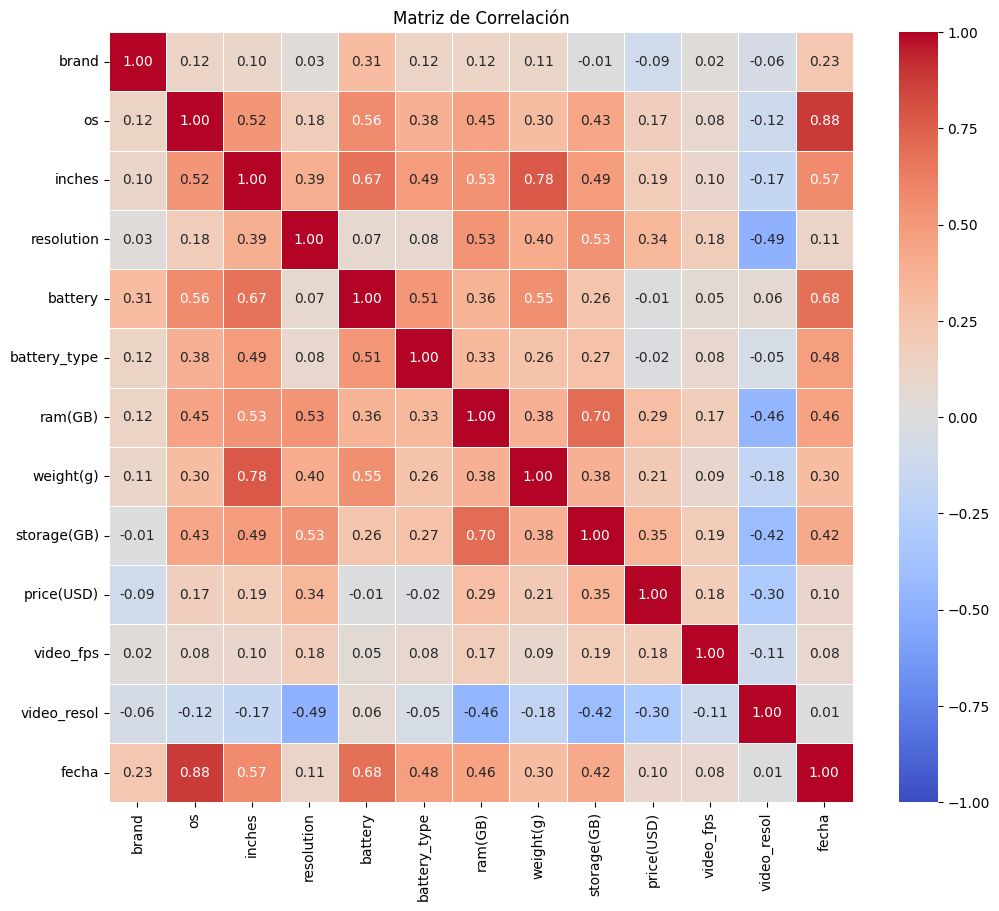

In [8]:
#Se procede a mostrar la matriz de correlacion, nos da informacion acerca de como estan relacionadas las variables.

corr_matrix = elements.corr()

#Se dibuja el mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

C:\Users\ese_1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\ese_1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


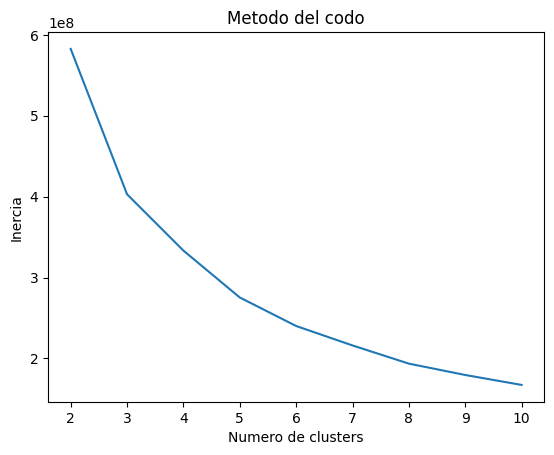

In [9]:
#Procedo a utilizar el metodo del codo: Esta tecnica es util para saber cuales son las mejores divisiones de nuestro grupo. El punto de las abscisas cuyos vertices sean mas pronunciados 
# tienden a ser mejores divisiones de grupos o clusters.   

#Metodo del Codo
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=16)
    kmeans.fit(elements)
    wcss.append(kmeans.inertia_)

#Metodo del codo
plt.plot(range(2, 11), wcss)
plt.title('Metodo del codo')
plt.xlabel('Numero de clusters')
plt.ylabel('Inercia')
plt.show()

#Parece que las mejores divisiones serian entre 3 o 5, procedo a evaluar ambas mediante las metricas vistas en clase.

El coeficiente de Silhouette promedio para 3 clústeres es: 0.409


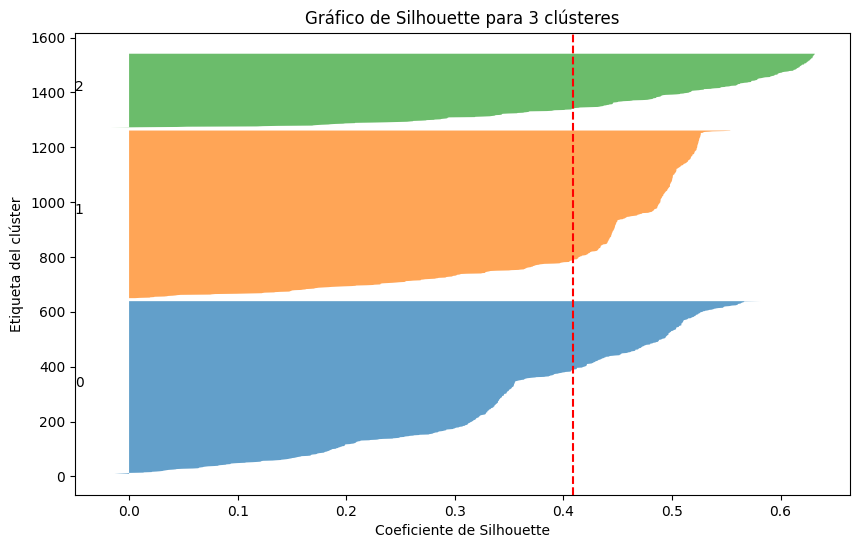

El coeficiente de Silhouette promedio para 5 clústeres es: 0.439


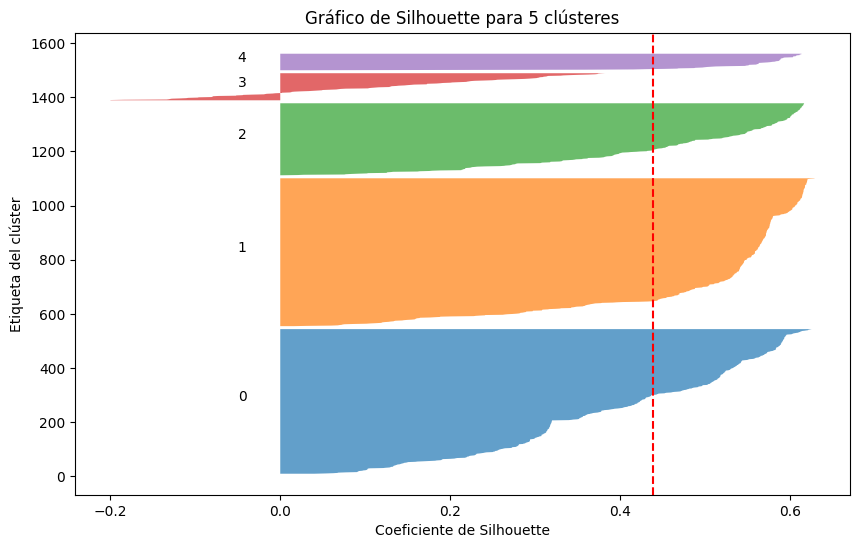

In [10]:
#Genero la funcion "plot_silhouette" para realizar clustering, calcular y graficar las puntuaciones de Silhouette.

def plot_silhouette(elements, n_clusters):

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(elements)
    
    # Calcular el coeficiente de Silhouette promedio
    silhouette_avg = silhouette_score(elements, cluster_labels)
    print(f"El coeficiente de Silhouette promedio para {n_clusters} clústeres es: {silhouette_avg:.3f}")

    # Obtener la puntuación de Silhouette para cada punto
    silhouette_values = silhouette_samples(elements, cluster_labels)

    # Crear un gráfico para visualizar las puntuaciones de Silhouette
    y_lower = 10
    for i in range(n_clusters):
        # Puntuaciones de Silhouette para las muestras de cada clúster
        ith_cluster_silhouette_values = silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.7)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))  # Etiqueta del clúster

        # Actualizar la posición para el siguiente clúster
        y_lower = y_upper + 10  # Espacio entre los clústeres

    plt.title(f"Gráfico de Silhouette para {n_clusters} clústeres")
    plt.xlabel("Coeficiente de Silhouette")
    plt.ylabel("Etiqueta del clúster")
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()

# Graficar para 3 clústeres
plt.figure(figsize=(10, 6))
plot_silhouette(elements, n_clusters=3)

# Graficar para 5 clústeres
plt.figure(figsize=(10, 6))
plot_silhouette(elements, n_clusters=5)


In [11]:
#Vemos que cuando dividimos por 5 grupos el cluster numero "3" tiene una parte de sus registros tienen coeficientes negativos, es decir estan mal agrupados. La division por 3 grupos no es la ideal, pero es menos mala.

#Casteo la funcion KMeans para obtener los grupos, obtendremos 3 grupos.
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=16)

cluster_labels = kmeans.fit_predict(elements)

kmeans.fit(elements)

#Con esto finalizaria el Desarrollo.

KMeans(n_clusters=3, n_init=10, random_state=16)

In [12]:
#Calculamos las distribucion de registros por grupos

# Obtener las etiquetas de los clusters
labels = kmeans.labels_

# Añadir las etiquetas de cluster al DataFrame original
elements['Cluster'] = labels

#creo una variable para contar los elementos en cada cluster
conteo_clusters = elements['Cluster'].value_counts()

# Mostrar el número de registros por cluster
print("Número de registros por cluster:")
print(conteo_clusters)

Número de registros por cluster:
Cluster
2    630
1    612
0    270
Name: count, dtype: int64


 # Análisis 

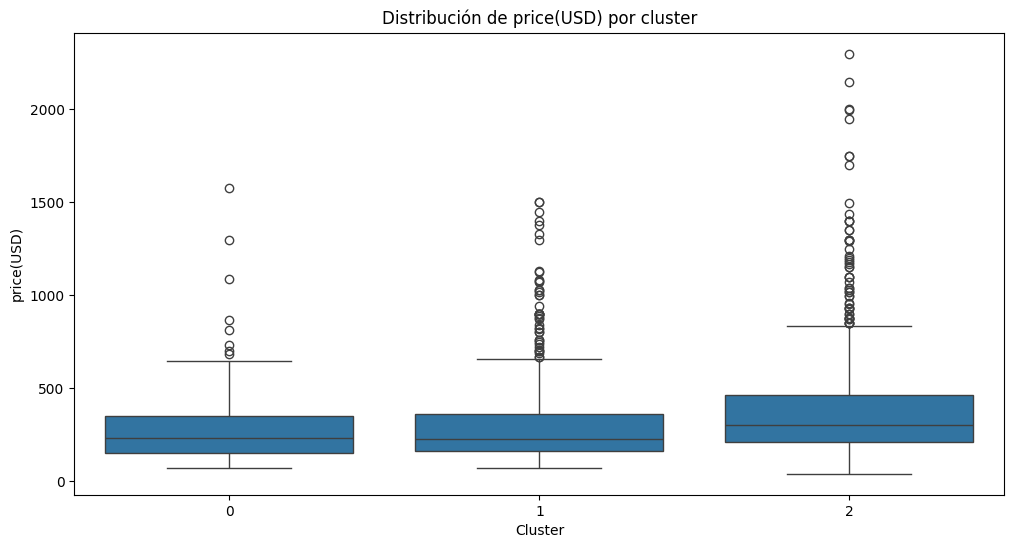

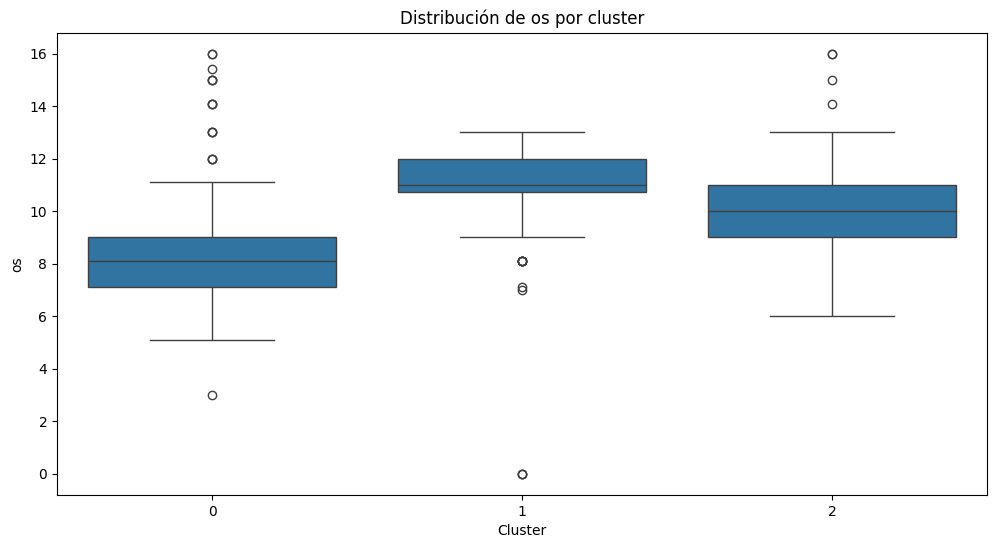

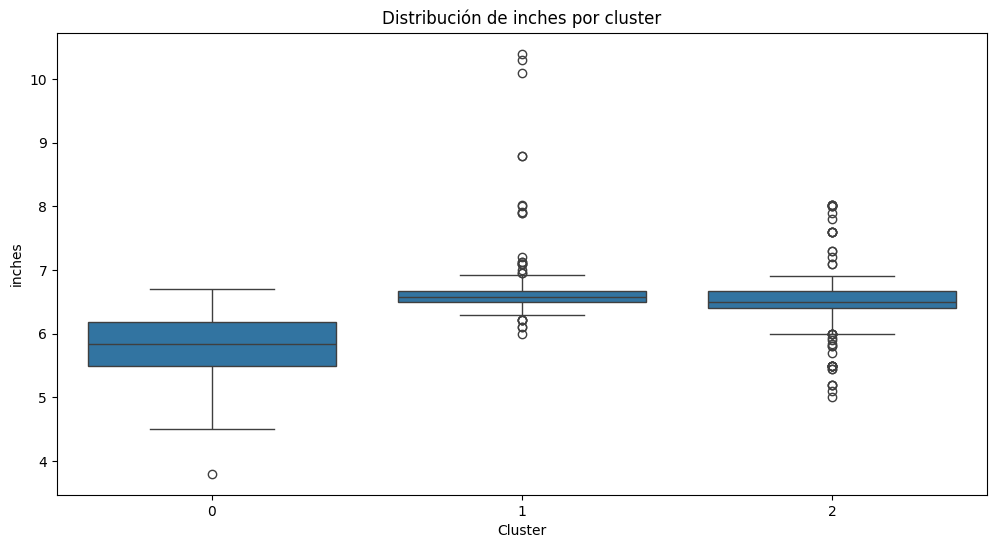

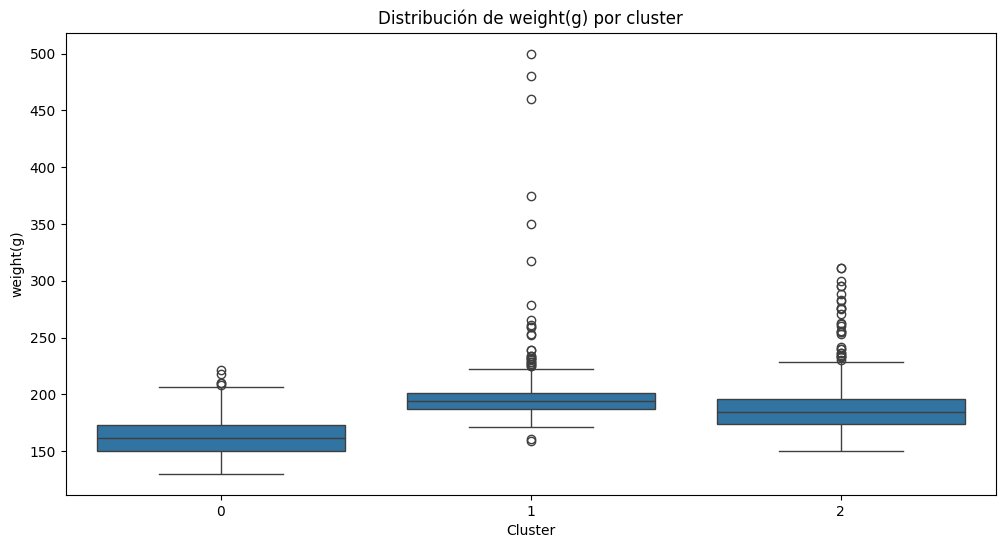

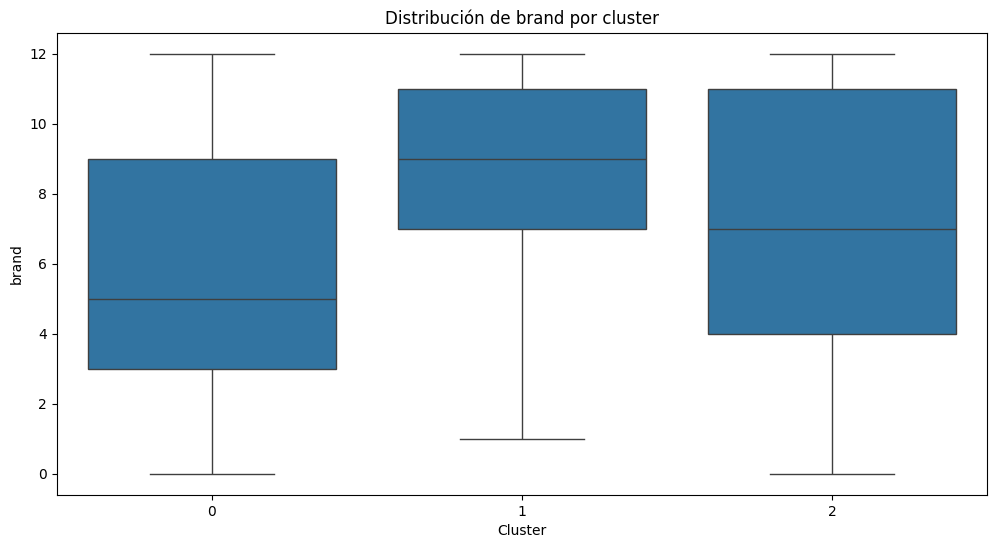

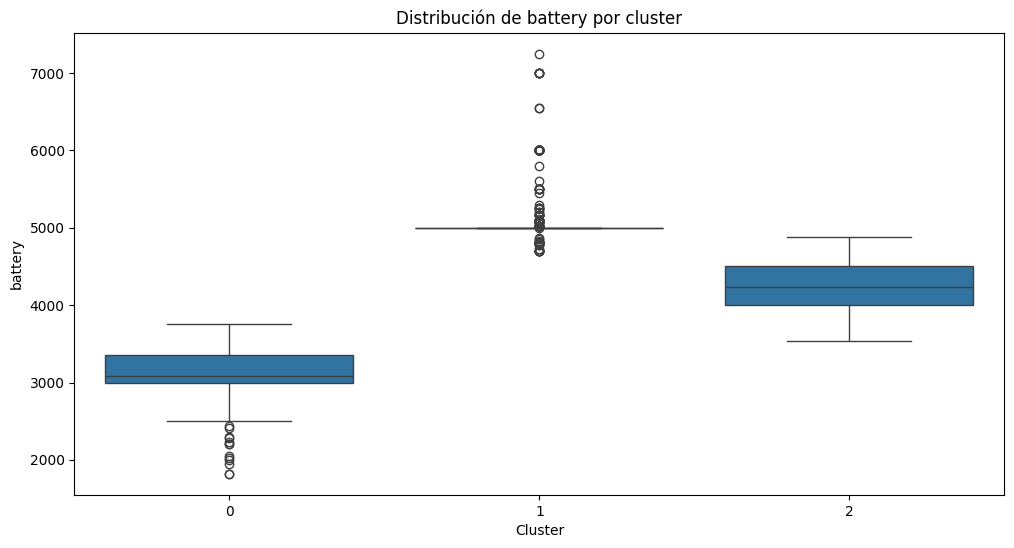

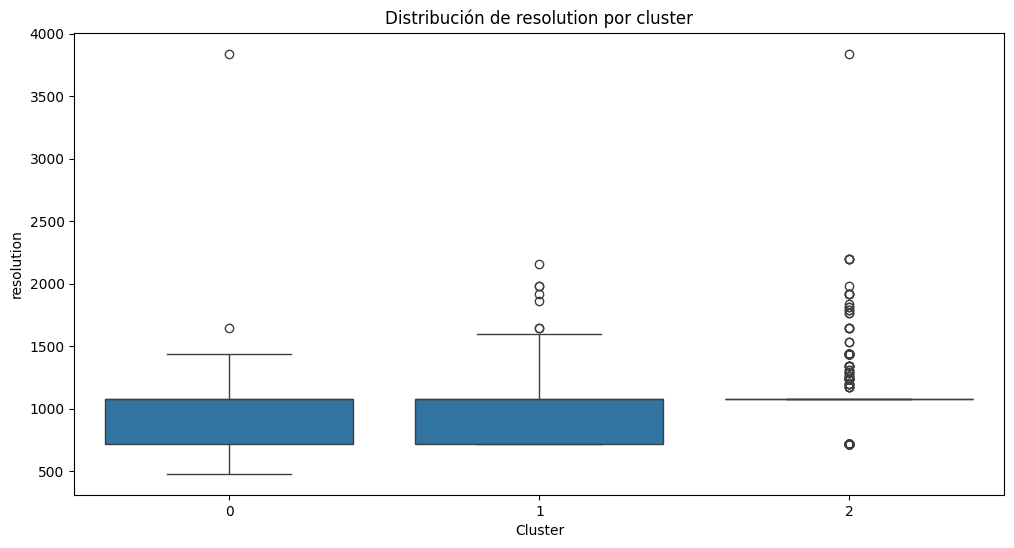

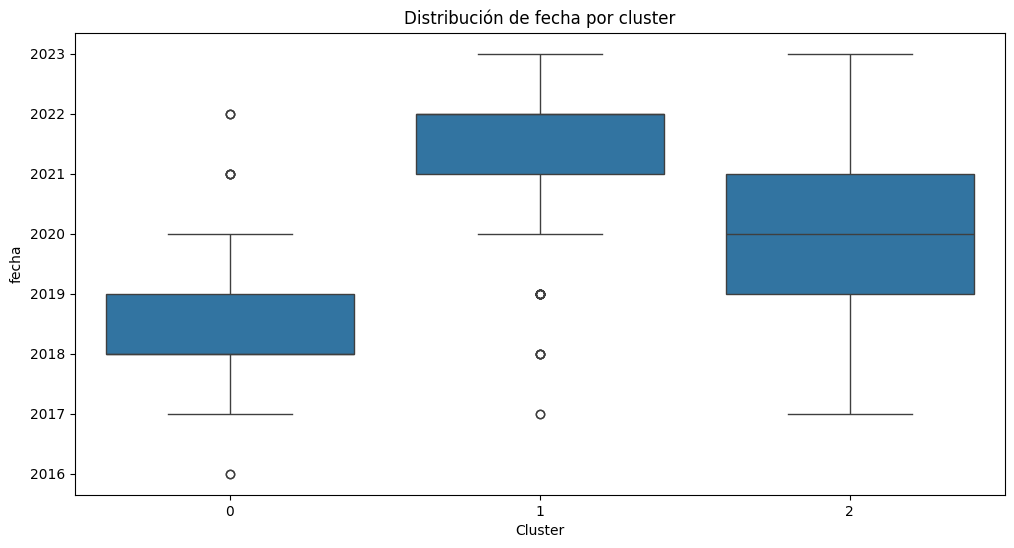

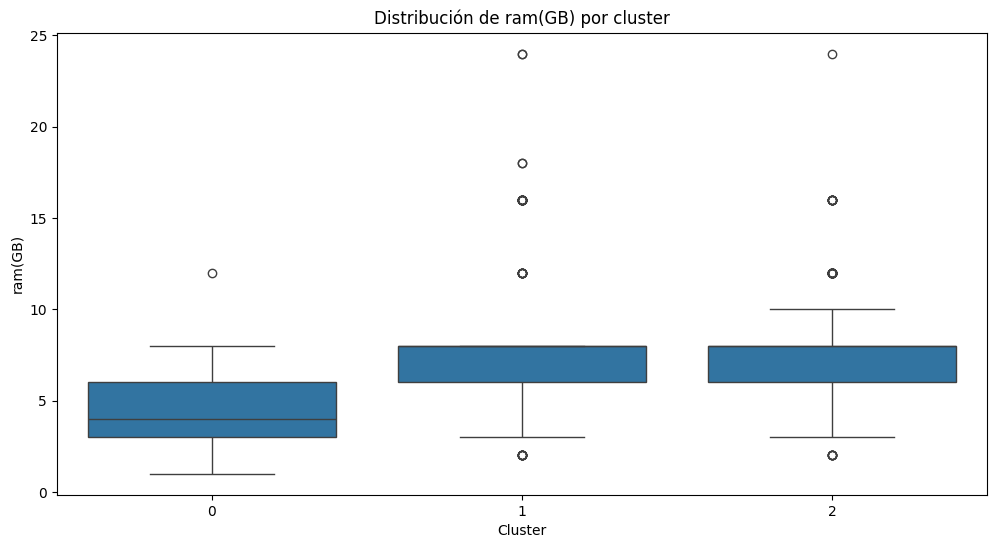

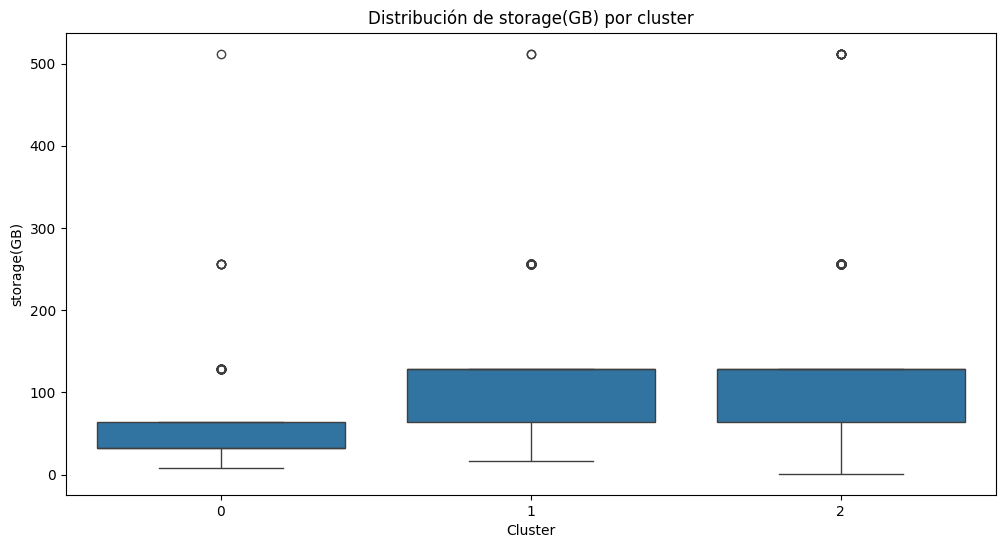

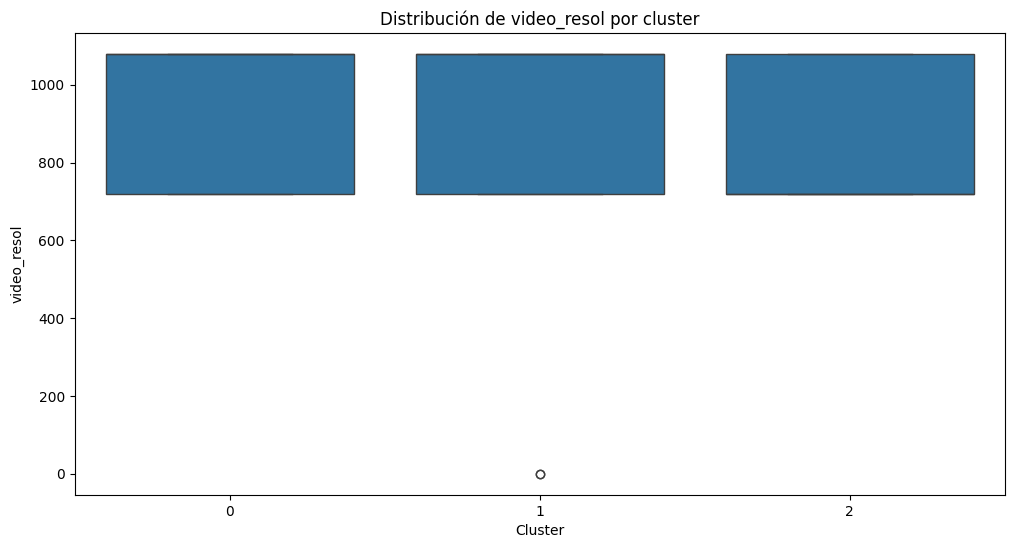

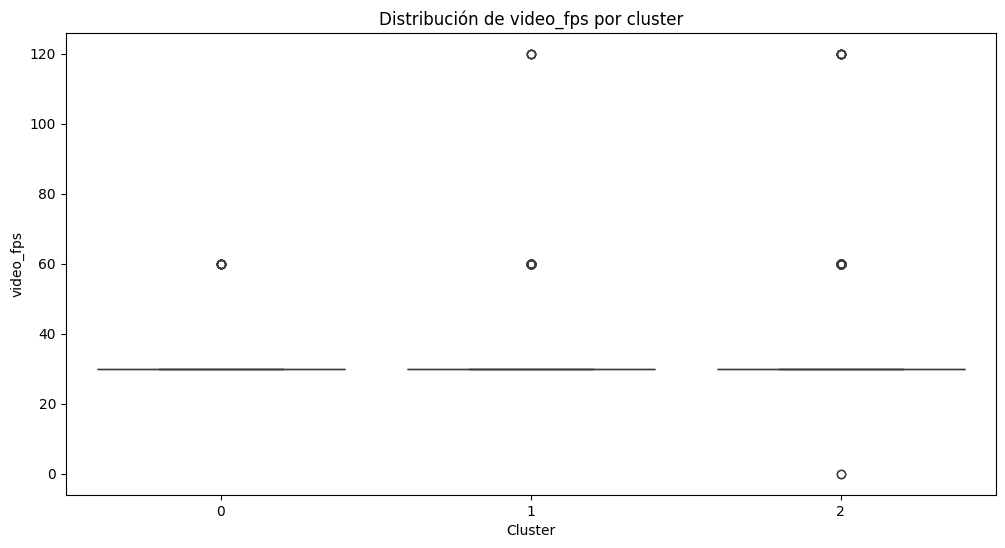

In [13]:

#Ahora queremos ver que relacion hay entre los clusters. Para eso veremos en varios graficos de bloxplot la distribucion de cada variable:

plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='price(USD)', data=elements)
plt.title('Distribución de price(USD) por cluster')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='os', data=elements)
plt.title('Distribución de os por cluster')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='inches', data=elements)
plt.title('Distribución de inches por cluster')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='weight(g)', data=elements)
plt.title('Distribución de weight(g) por cluster')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='brand', data=elements)
plt.title('Distribución de brand por cluster')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='battery', data=elements)
plt.title('Distribución de battery por cluster')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='resolution', data=elements)
plt.title('Distribución de resolution por cluster')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='fecha', data=elements)
plt.title('Distribución de fecha por cluster')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='ram(GB)', data=elements)
plt.title('Distribución de ram(GB) por cluster')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='storage(GB)', data=elements)
plt.title('Distribución de storage(GB) por cluster')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='video_resol', data=elements)
plt.title('Distribución de video_resol por cluster')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='video_fps', data=elements)
plt.title('Distribución de video_fps por cluster')
plt.show()

In [ ]:
#Analizando los graficos vemos que las distribuciones de las variables brand,inches,resolution,ram(GB),weight(g),storage(GB),price(USD),video_fps,video_resol son similares en los 3 clusters.
# Las variables que mas marcan la division son fecha, os y battery. 

# Si Revisamos la matriz de correlaciones vemos que fecha-os y fecha-battery esta estrechamente asociadas (0.88 y 0.68 respectivamente).

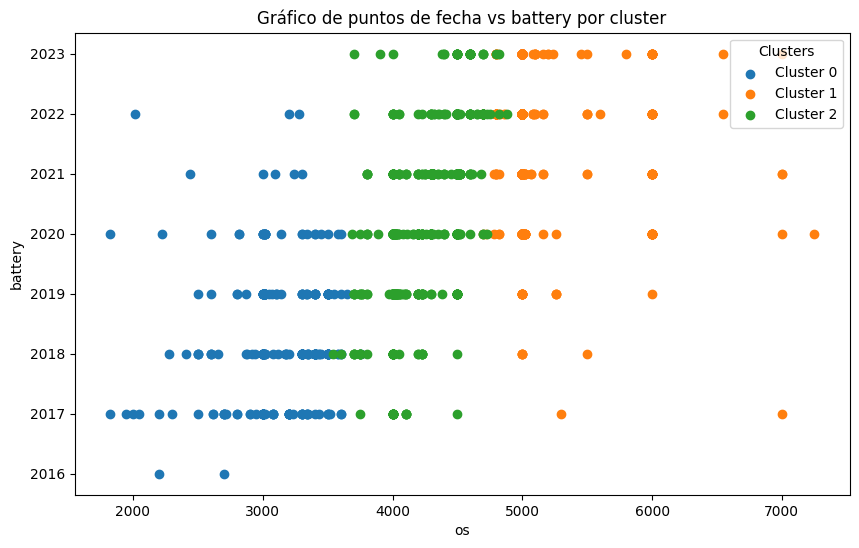

In [17]:
# Graficamente:
plt.figure(figsize=(10, 6))

# Graficar cada cluster por separado
for cluster in range(3):
    cluster_data = elements[elements['Cluster'] == cluster]
    plt.scatter(cluster_data['battery'], cluster_data['fecha'], label=f'Cluster {cluster}', marker='o')

# Añadir etiquetas y título
plt.title(f'Gráfico de puntos de fecha vs battery por cluster')
plt.ylabel('battery')
plt.xlabel('os')
plt.legend(title="Clusters")

# Conclusiones

Observamos claramente los 3 cluster diferenciados, representado los equipos del cluster 0 los mas antiguos y los 1 y 2 los mas modernos. Los del Cluster 1 tienen una bateria mas potente, observando la tabla de correlaciones tambien podemos afirmar que estos equipos tienen mejor pantalla y sistema operativo pero mayor peso. La segmentacion realizada podria servir en varios campos de la industria de telefonia celular, ya sea en el desarrollo de los equipos, al ayudar a las marcas a identificar tendencias tecnológicas y optimizar lanzamientos según la demanda del mercado, como al desarrollo de estrategias de marketing, por ejemplo, ofrenciendo, segun el alcance economico proyectado del cliente un equipo, un celular del cluster correspondiente. 